
#### _ML продвинутые методы / ДЗ №1 / Практическая часть / Задача 3_

## 3. _Boosting vs Bagging_ 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [3]:
from sklearn.datasets import load_diabetes

data = load_diabetes()

X = data.data
y = data.target

X.shape, y.shape

((442, 10), (442,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=223)

print(X_train.shape, X_test.shape)

(353, 10) (89, 10)


### 3.1 _DecisionTreeRegressor_ 

In [5]:
%%time

dtr = DecisionTreeRegressor()

dtr_grid_params = {
    'max_depth' : list(range(2, 10)),
    'max_features' : [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    'min_samples_leaf' : list(range(1, 15))
}

gs_dtr = GridSearchCV(dtr, dtr_grid_params, scoring='neg_mean_squared_error', cv=4, iid=True, n_jobs=-1)
gs_dtr.fit(X_train, y_train)

best_dtr = gs_dtr.best_estimator_

Wall time: 4.58 s


In [6]:
best_dtr

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=0.7,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=13,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [7]:
-gs_dtr.best_score_

3524.077836890143

In [8]:
def print_scores(regr_name, dataset_name, y_test, y_pred):
    print('[{}] R2 ({}): {:.3f}'.format(regr_name, dataset_name, r2_score(y_test, y_pred)))
    print('[{}] MSE ({}): {:.3f}'.format(regr_name, dataset_name, mean_squared_error(y_test, y_pred)))
    print()
    print('*' * 50)

In [9]:
y_dtr_pred = best_dtr.predict(X_test)

In [10]:
print_scores('DecisionTreeRegressor', 'train', y_train, best_dtr.predict(X_train))
print_scores('DecisionTreeRegressor', 'test', y_test, y_dtr_pred)

[DecisionTreeRegressor] R2 (train): 0.582
[DecisionTreeRegressor] MSE (train): 2452.073

**************************************************
[DecisionTreeRegressor] R2 (test): 0.397
[DecisionTreeRegressor] MSE (test): 3708.473

**************************************************


### 3.2 _RandomForestRegressor_

Параметры для решающего дерева возьмём равными найденным выше для `DecisionTreeRegressor`.

In [11]:
%%time

rfr_params = {k:v for (k,v) in best_dtr.get_params().items() 
                  if k in ['max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split']}

rfr = RandomForestRegressor(n_estimators=50, **rfr_params)

print( -cross_val_score(rfr, X_train, y_train, cv=4, scoring='neg_mean_squared_error').mean() )

3211.8958624491647
Wall time: 192 ms


In [12]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features=0.7, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=13, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [13]:
y_rfr_pred = rfr.predict(X_test)

In [14]:
print_scores('RandomForestRegressor', 'train', y_train, rfr.predict(X_train))
print_scores('RandomForestRegressor', 'test', y_test, y_rfr_pred)

[RandomForestRegressor] R2 (train): 0.603
[RandomForestRegressor] MSE (train): 2330.276

**************************************************
[RandomForestRegressor] R2 (test): 0.497
[RandomForestRegressor] MSE (test): 3096.330

**************************************************


#### 3.2.1 _Number of trees in RandomForest_

In [15]:
from tqdm import tqdm

In [16]:
n_trees = np.arange(5,400,10)
scores = []

rfr_params = {k:v for (k,v) in rfr.get_params().items() 
                        if k in ['max_depth', 'max_features', 'min_samples_leaf', 
                                 'min_samples_split', 'min_weight_fraction_leaf']}

for n in tqdm(n_trees):
    rfr = RandomForestRegressor(n_estimators=n, n_jobs=-1, **rfr_params)
    scores.append(-cross_val_score(rfr, X, y, cv=4, scoring='neg_mean_squared_error').mean())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:44<00:00,  1.60s/it]


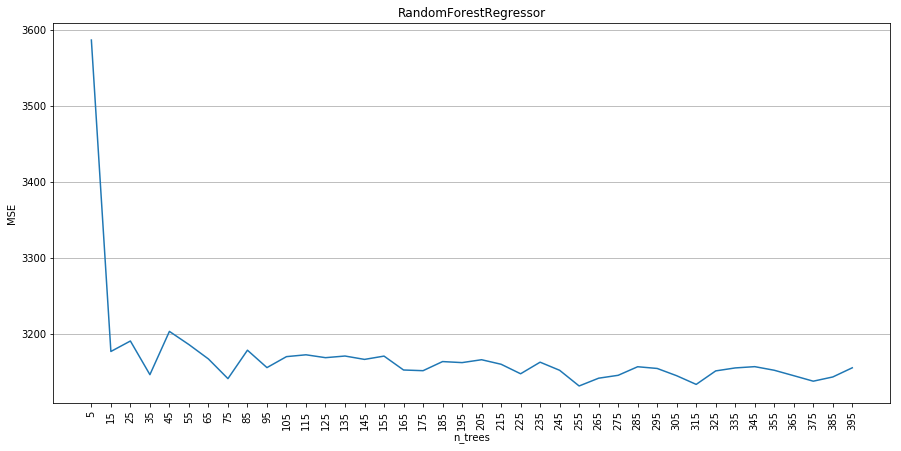

In [17]:
plt.figure(figsize = (15, 7))
plt.plot(scores)
plt.xticks(np.arange(len(n_trees)), n_trees, rotation='vertical')
plt.grid(axis='y')
plt.ylabel('MSE')
plt.xlabel('n_trees')
plt.title('RandomForestRegressor');

### 3.3 _GradientBoostingRegressor_

In [18]:
%%time

gbr = GradientBoostingRegressor(n_estimators=10)

gbr_grid_params = {
    'max_depth' : list(range(1, 6)),
    'learning_rate' : np.linspace(0.1, 1, 10),
    'max_features' : [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    'min_samples_leaf' : list(range(1, 10))
}

gs_gbr = GridSearchCV(gbr, gbr_grid_params, scoring='neg_mean_squared_error', cv=4, iid=True, n_jobs=-1)
gs_gbr.fit(X_train, y_train)

best_gbr = gs_gbr.best_estimator_

Wall time: 23.8 s


In [19]:
best_gbr

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.4, loss='ls', max_depth=3, max_features=0.2,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
y_gbr_pred = best_gbr.predict(X_test) 

In [21]:
print_scores('GradientBoostingRegressor', 'train', y_train, best_gbr.predict(X_train))
print_scores('GradientBoostingRegressor', 'test', y_test, y_gbr_pred)

[GradientBoostingRegressor] R2 (train): 0.663
[GradientBoostingRegressor] MSE (train): 1977.171

**************************************************
[GradientBoostingRegressor] R2 (test): 0.491
[GradientBoostingRegressor] MSE (test): 3134.302

**************************************************


#### 3.3.1 _Number of trees in GradientBoosting_

In [22]:
n_trees = np.concatenate((np.array([1]), np.arange(5, 205, 5)))
scores = []

for n in tqdm(n_trees):
    best_gbr.n_estimators = n
    scores.append(-cross_val_score(best_gbr, X, y, cv=4, scoring='neg_mean_squared_error').mean())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:03<00:00,  4.51it/s]


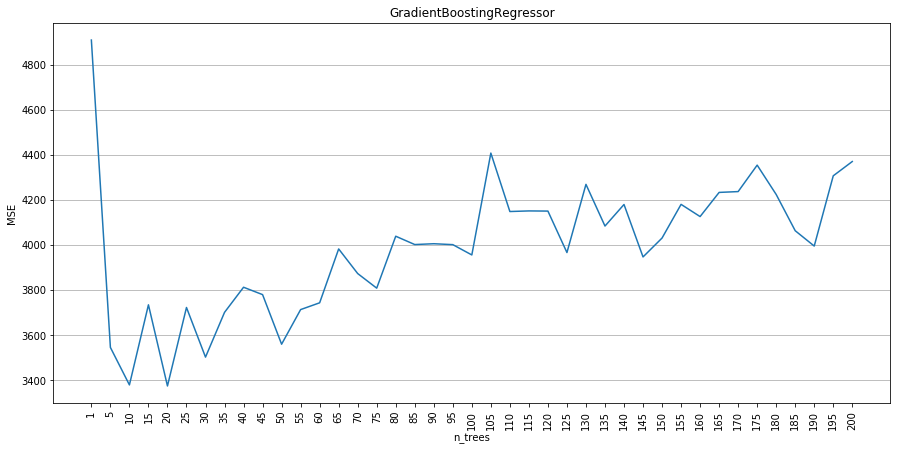

In [23]:
plt.figure(figsize = (15, 7))
plt.plot(scores)
plt.xticks(np.arange(len(n_trees)), n_trees, rotation='vertical')
plt.grid(axis='y')
plt.ylabel('MSE')
plt.xlabel('n_trees')
plt.title('GradientBoostingRegressor');